In [1]:
import numpy as np 
import pandas as pd 
import polars as pl
import os
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor, Pool
warnings.simplefilter('ignore')

In [2]:
# Load datasets
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
original = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')

# Define a function to extract and convert numeric values from strings
def extract_numeric_columns(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: int(''.join(re.findall(r'\d+', x))))
    return df

# Apply the function to the 'milage' and 'price' columns in the 'original' dataframe
original = extract_numeric_columns(original, ['milage', 'price'])

# Combine the 'train' and 'original' datasets
train = pd.concat([train, original], ignore_index=True)

# Insert the ensemble model code here
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor # LightGBM not available in this environment
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Preprocess the data
def preprocess_data(df):
    # Fill missing values
    df.fillna('Unknown', inplace=True)

    # Label encode categorical columns
    label_enc_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
    le = LabelEncoder()
    for col in label_enc_cols:
        df[col] = le.fit_transform(df[col])
    
    # Scale numerical columns
    scaler = StandardScaler()
    num_cols = ['model_year', 'milage']
    df[num_cols] = scaler.fit_transform(df[num_cols])
    
    return df

# Preprocess the training data
train_df_preprocessed = preprocess_data(train.copy())

# Split features and target
X = train_df_preprocessed.drop(columns=['id', 'price'])
y = train_df_preprocessed['price']

# Train-Test Split for local validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
# lightgbm_model = LGBMRegressor() # LightGBM not available in this environment
xgb_model = XGBRegressor()
catboost_model = CatBoostRegressor(verbose=0)

# Define stacking model
stacking_model = StackingRegressor(
    estimators=[
        # ('lgbm', lightgbm_model), # Commented due to unavailability
        ('xgb', xgb_model),
        ('catboost', catboost_model)
    ],
    final_estimator=Ridge()
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Validate the model
y_pred = stacking_model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 75334.86164641594


In [3]:
def style_dataframe(df):
    return (df.style
            .set_table_styles([
                {'selector': 'thead th', 'props': [
                    ('background-color', '#4CAF50'),  # Green header background
                    ('color', '#FFFFFF'),             # White text
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('border', '1px solid #388E3C')   # Dark green border
                ]},
                {'selector': 'tbody td', 'props': [
                    ('background-color', '#FAFAFA'),  # Light background
                    ('border', '1px solid #E0E0E0'),  # Light gray border
                    ('color', '#212121')              # Dark gray text
                ]}
            ])
            .set_properties(**{'text-align': 'center'})
            .set_table_attributes('style="width:100%;"')
            .hide(axis='index'))


In [4]:
styled_subset_train = style_dataframe(train.head(10))
styled_subset_train

id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0.000000,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1.000000,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2.000000,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900
3.000000,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4.000000,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
5.000000,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950
6.000000,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500
7.000000,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,White,Gray,None reported,Yes,12500
8.000000,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890
9.000000,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000


In [5]:
categorical_features = train.select_dtypes(include='object').columns.tolist()
numerical_features = [col for col in train.select_dtypes(exclude='object') if col not in ['price', 'id']]

styled_numerical_df = style_dataframe(pd.DataFrame({'Numerical Variables': numerical_features}))
styled_numerical_df

Numerical Variables
model_year
milage


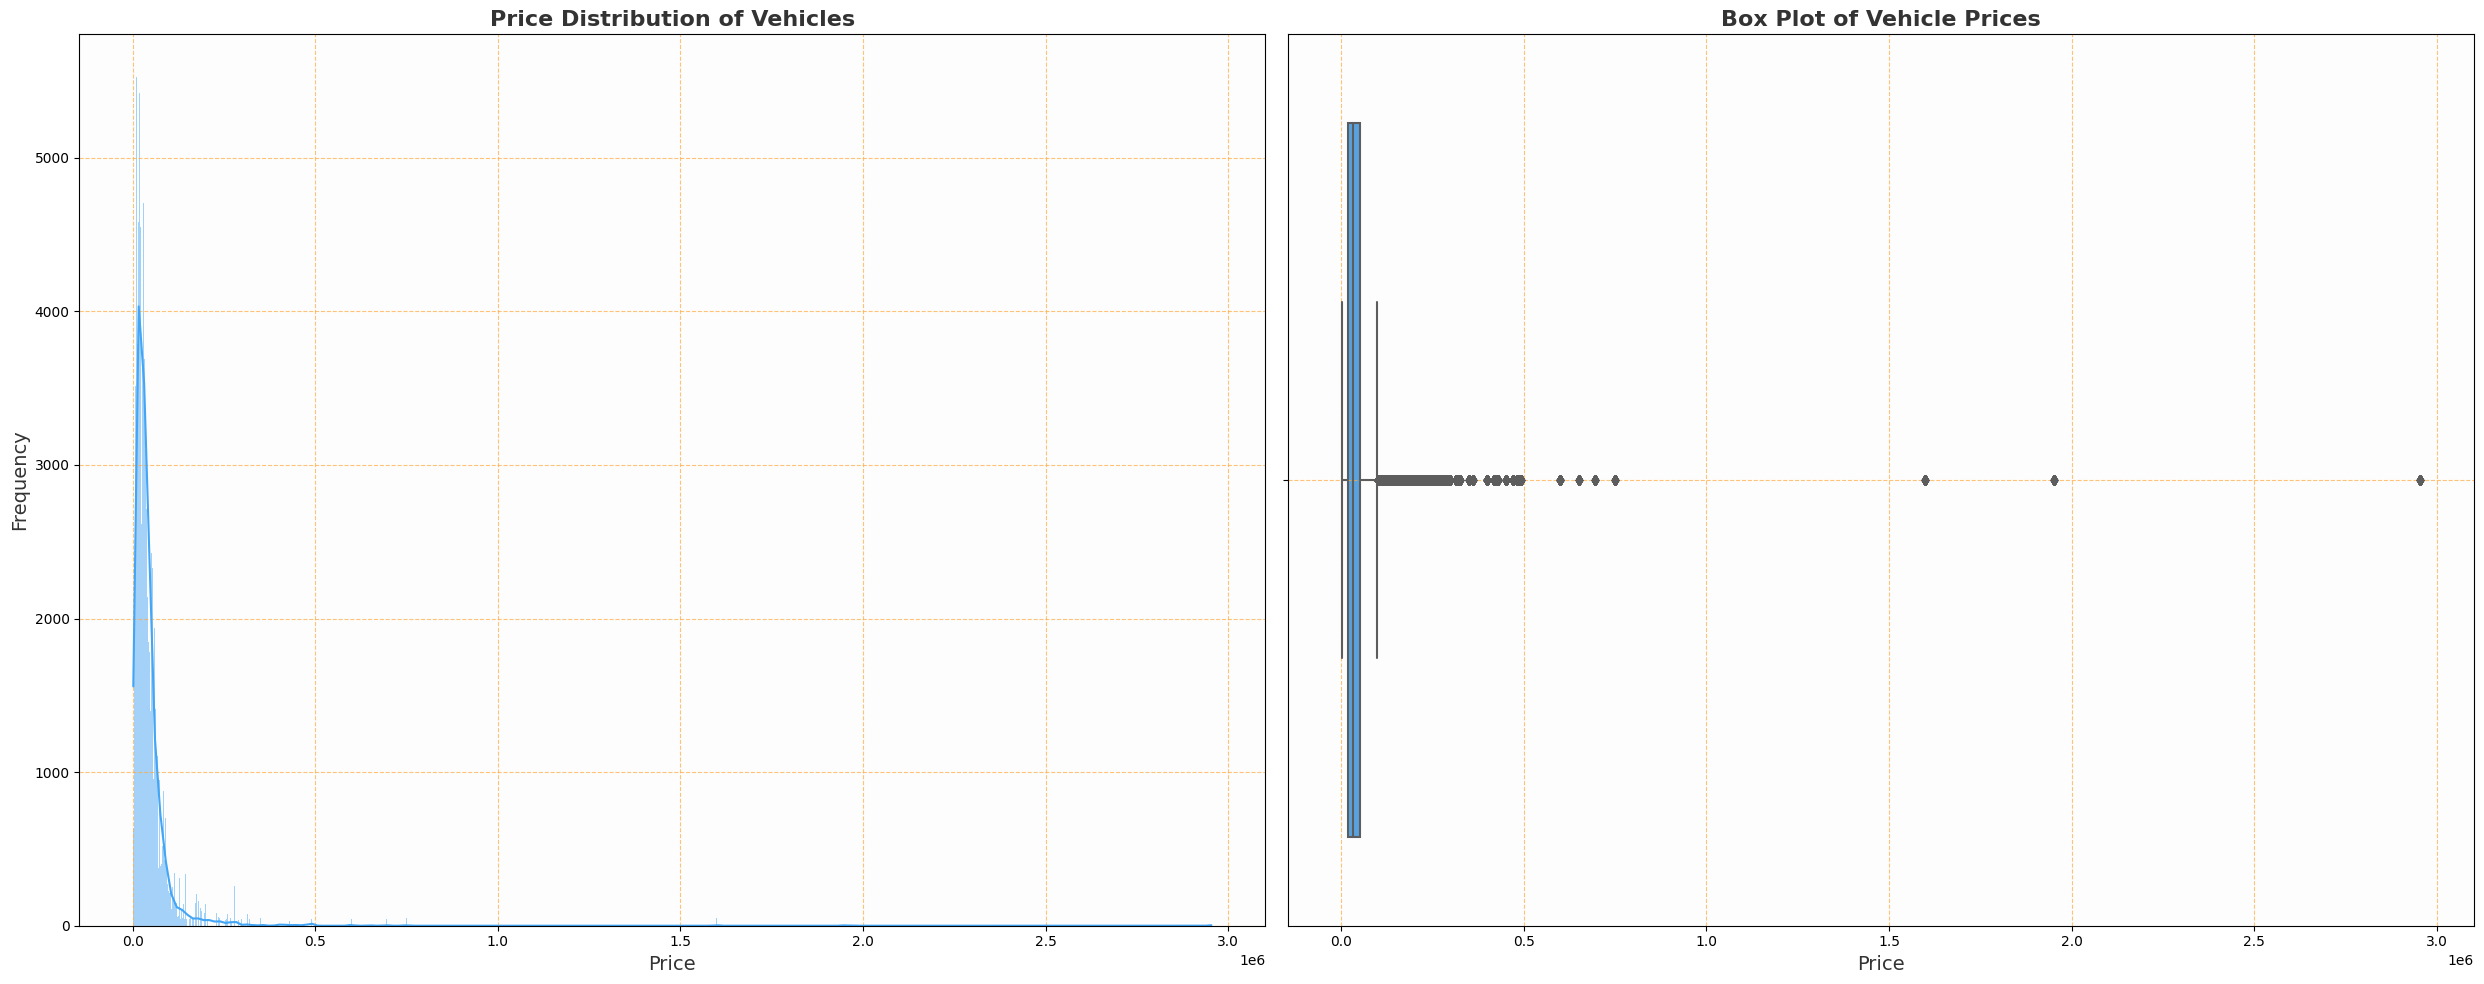

In [6]:
# Set up figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Define colors
colors = {'hist': '#42A5F5', 'box': '#42A5F5', 'bg': '#F5F5F5', 'grid': '#FFAB40', 'text': '#333333'}

# Set aesthetic style
sns.set(style="whitegrid")

# Histogram
sns.histplot(train['price'], kde=True, ax=ax[0], color=colors['hist'])
ax[0].set_title('Price Distribution of Vehicles', fontsize=16, fontweight='bold', color=colors['text'])
ax[0].set_xlabel('Price', fontsize=14, color=colors['text'])
ax[0].set_ylabel('Frequency', fontsize=14, color=colors['text'])
ax[0].patch.set_facecolor(colors['bg'])
ax[0].patch.set_alpha(0.1)
ax[0].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])

# Box Plot
sns.boxplot(x=train['price'], ax=ax[1], color=colors['box'])
ax[1].set_title('Box Plot of Vehicle Prices', fontsize=16, fontweight='bold', color=colors['text'])
ax[1].set_xlabel('Price', fontsize=14, color=colors['text'])
ax[1].patch.set_facecolor(colors['bg'])
ax[1].patch.set_alpha(0.1)
ax[1].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


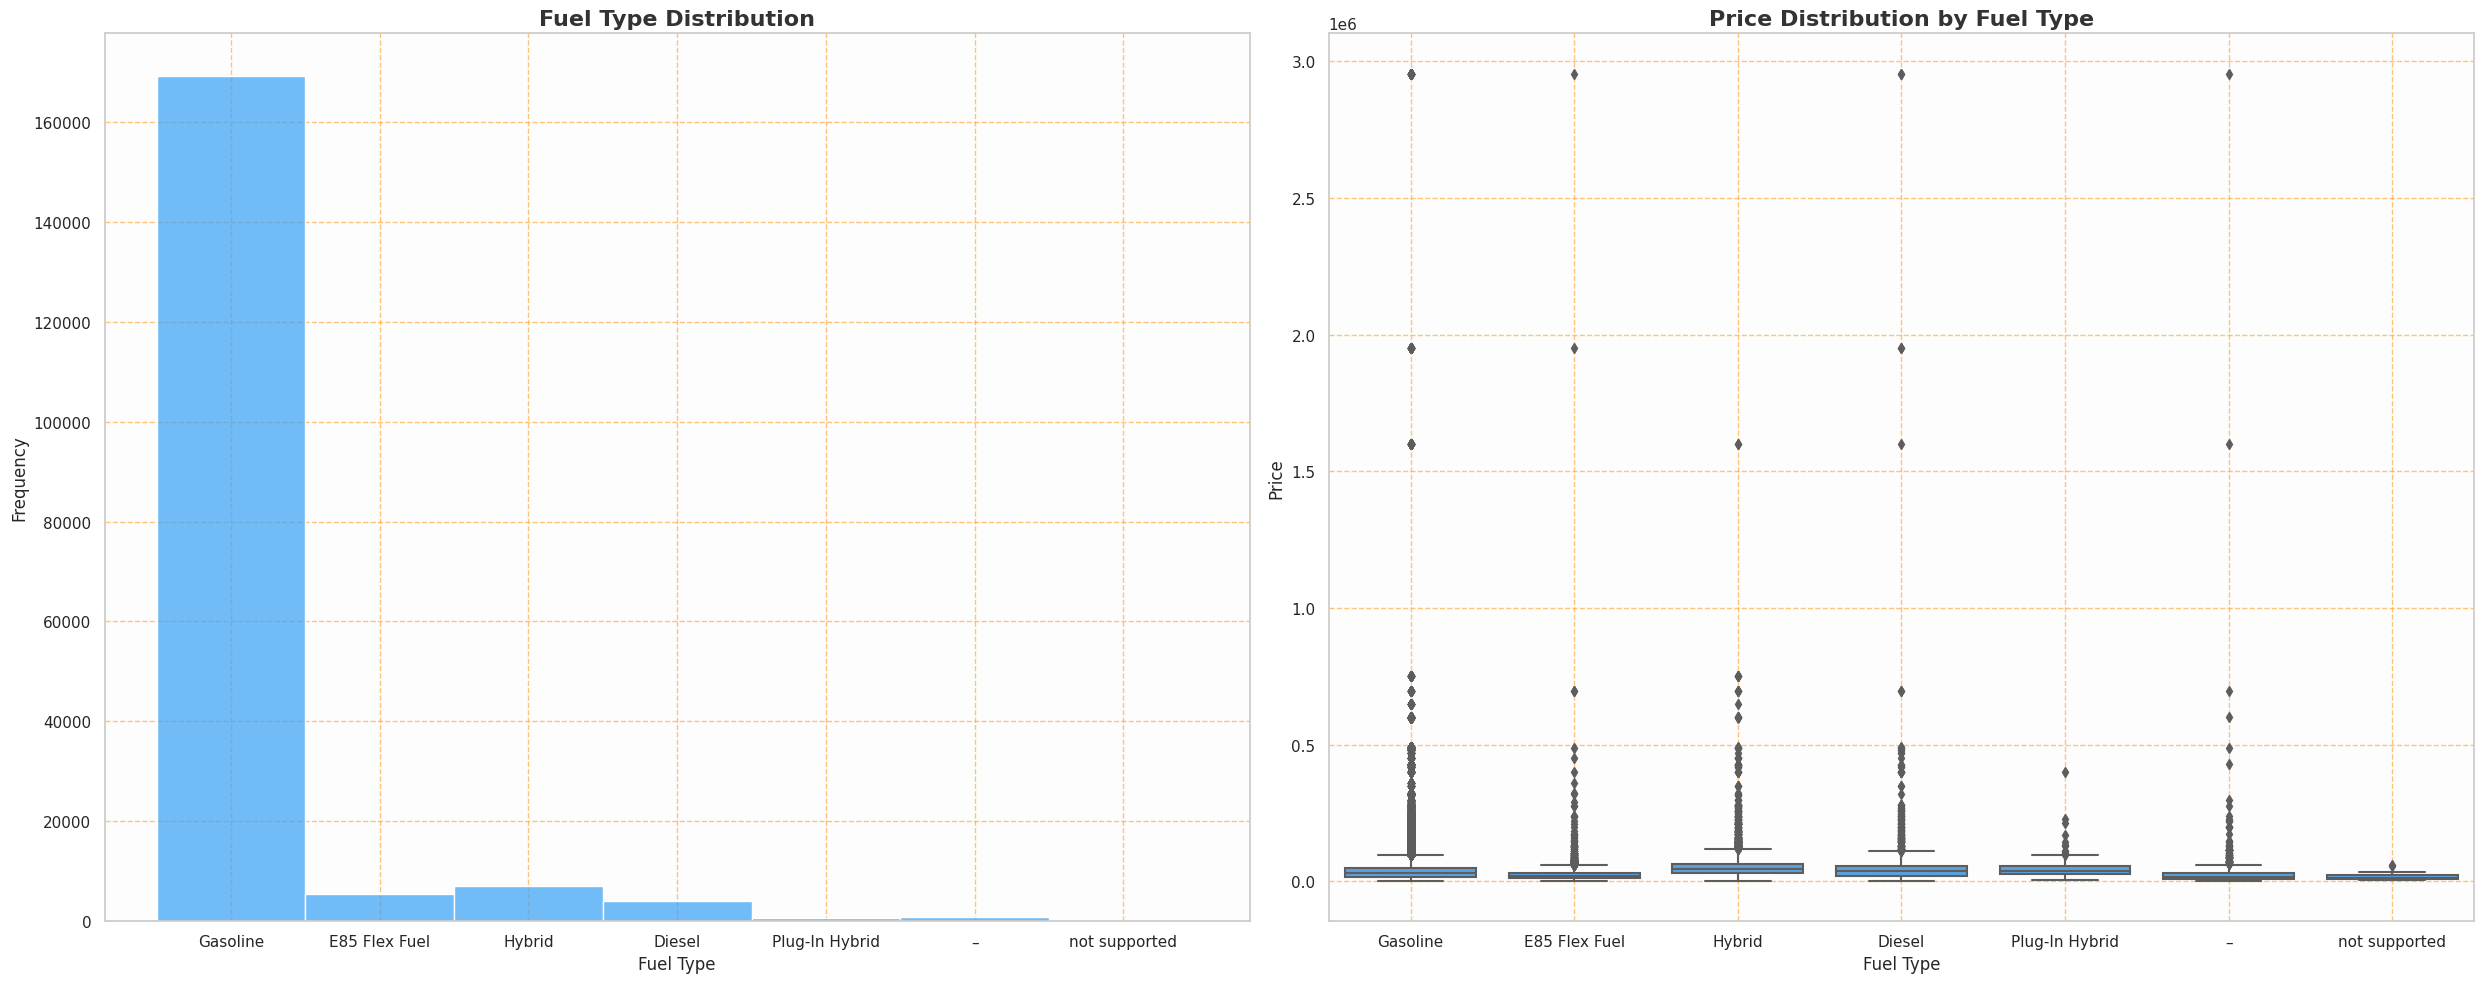

In [7]:
# Set up figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Define colors
colors = {'hist': '#42A5F5', 'box': '#42A5F5', 'bg': '#F5F5F5', 'grid': '#FFAB40', 'text': '#333333'}

# Set general aesthetic style
sns.set(style="whitegrid")

# Histogram for Fuel Type
sns.histplot(train['fuel_type'], kde=False, ax=ax[0], color=colors['hist'])
ax[0].set_title('Fuel Type Distribution', fontsize=16, fontweight='bold', color=colors['text'])
ax[0].set(xlabel='Fuel Type', ylabel='Frequency')
ax[0].patch.set(facecolor=colors['bg'], alpha=0.1)
ax[0].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])

# Box Plot for Price by Fuel Type
sns.boxplot(x='fuel_type', y='price', data=train, ax=ax[1], color=colors['box'])
ax[1].set_title('Price Distribution by Fuel Type', fontsize=16, fontweight='bold', color=colors['text'])
ax[1].set(xlabel='Fuel Type', ylabel='Price')
ax[1].patch.set(facecolor=colors['bg'], alpha=0.1)
ax[1].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


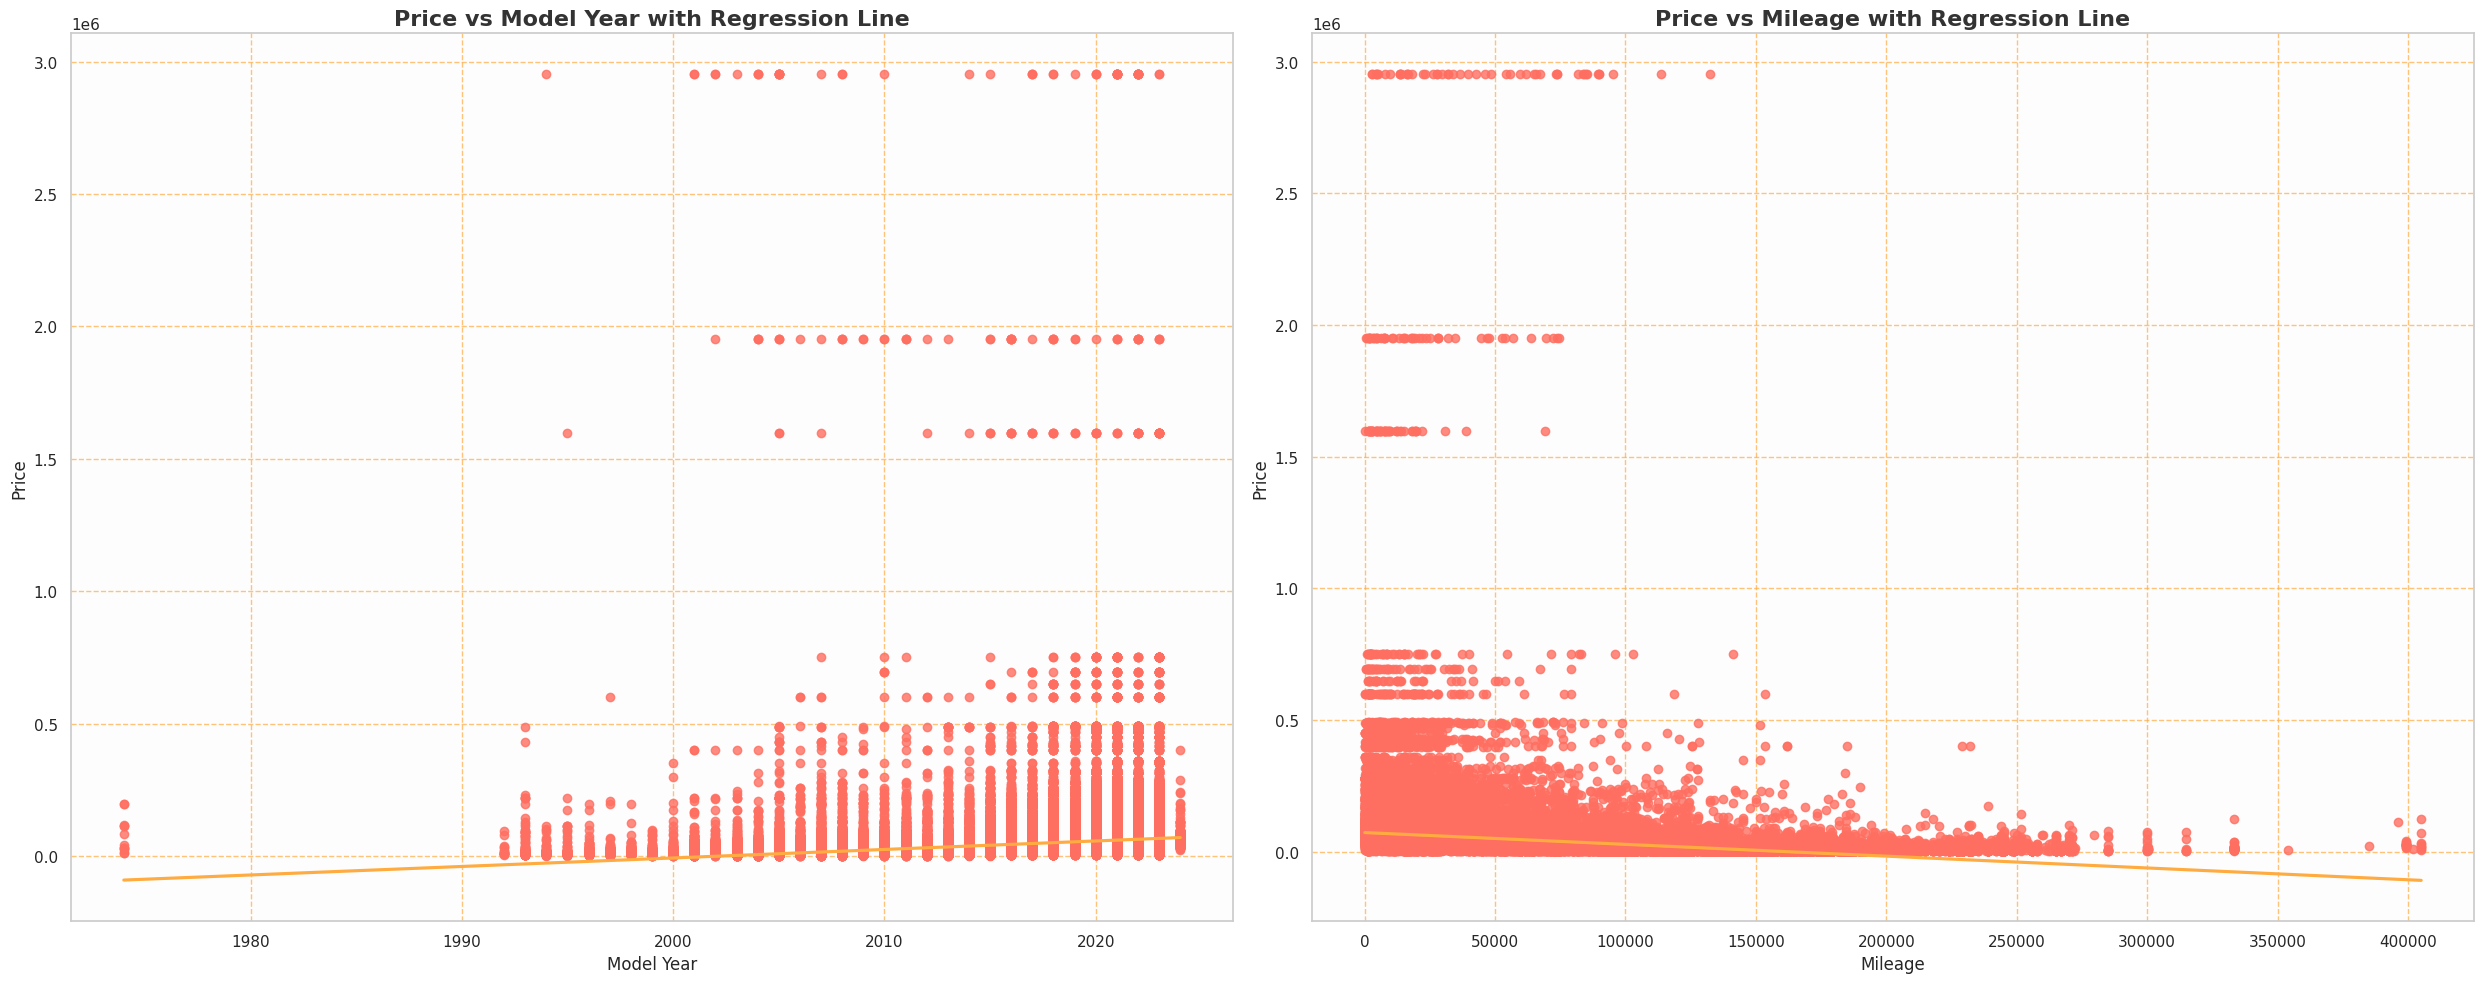

In [8]:
# Set up figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Define colors
colors = {'scatter': '#FF6F61', 'line': '#FFAB40', 'bg': '#F5F5F5', 'grid': '#FFAB40', 'text': '#333333'}

# Set general aesthetic style
sns.set(style="whitegrid")

# Scatter Plot for Price vs Model Year
sns.regplot(x='model_year', y='price', data=train, ax=ax[0], scatter_kws={'color': colors['scatter']}, line_kws={'color': colors['line']})
ax[0].set_title('Price vs Model Year with Regression Line', fontsize=16, fontweight='bold', color=colors['text'])
ax[0].set(xlabel='Model Year', ylabel='Price')
ax[0].patch.set(facecolor=colors['bg'], alpha=0.1)
ax[0].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])

# Scatter Plot for Price vs Mileage
sns.regplot(x='milage', y='price', data=train, ax=ax[1], scatter_kws={'color': colors['scatter']}, line_kws={'color': colors['line']})
ax[1].set_title('Price vs Mileage with Regression Line', fontsize=16, fontweight='bold', color=colors['text'])
ax[1].set(xlabel='Mileage', ylabel='Price')
ax[1].patch.set(facecolor=colors['bg'], alpha=0.1)
ax[1].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


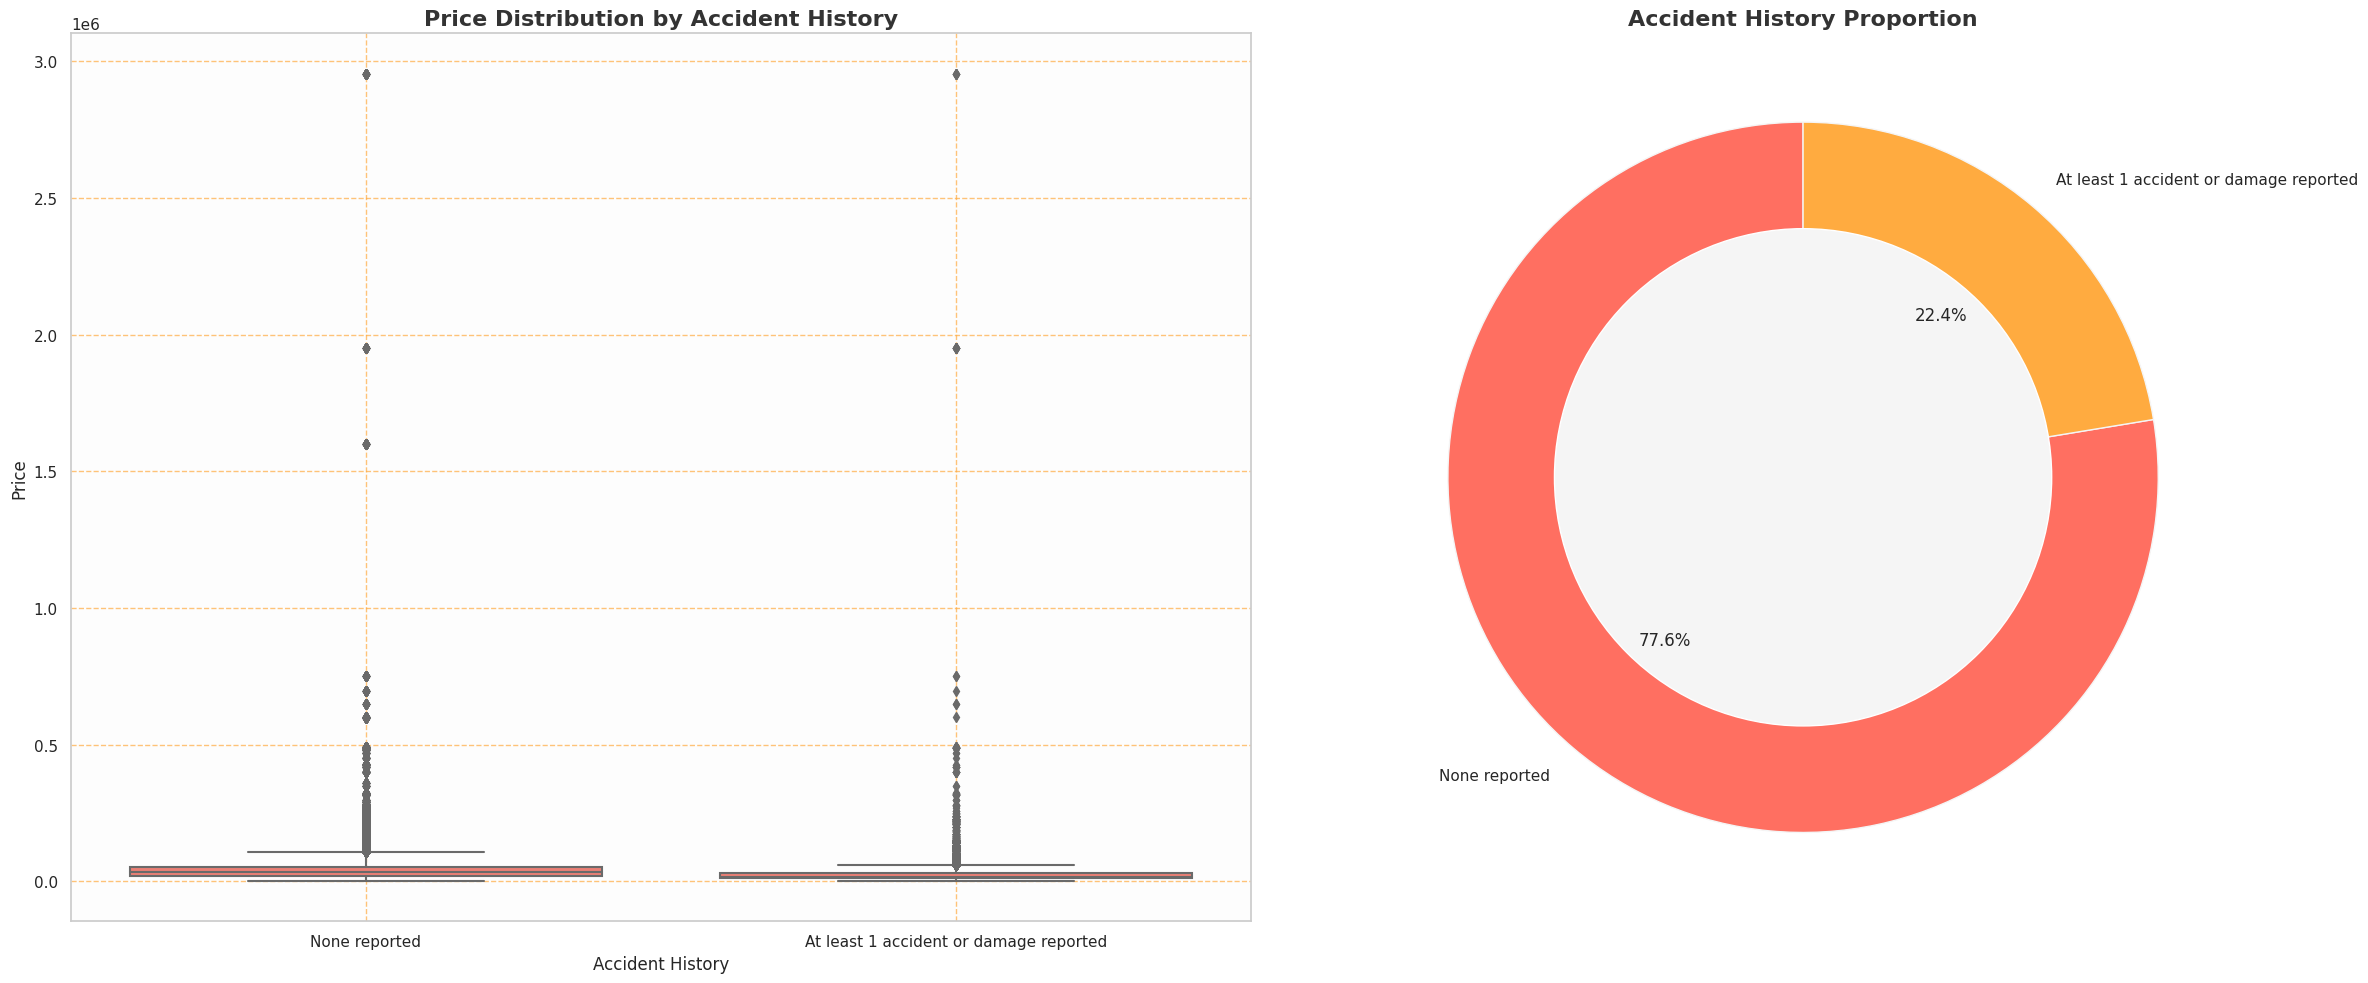

In [9]:
# Set up figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Define colors
colors = {'box': '#FF6F61', 'bg': '#F5F5F5', 'grid': '#FFAB40', 'text': '#333333', 'donut': ['#FF6F61', '#FFAB40']}

# Set general aesthetic style
sns.set(style="whitegrid")

# Box Plot for Price by Accident History
sns.boxplot(x='accident', y='price', data=train, ax=ax[0], color=colors['box'])
ax[0].set_title('Price Distribution by Accident History', fontsize=16, fontweight='bold', color=colors['text'])
ax[0].set(xlabel='Accident History', ylabel='Price')
ax[0].patch.set(facecolor=colors['bg'], alpha=0.1)
ax[0].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])

# Donut Chart for Accident History Proportion
accident_counts = train['accident'].value_counts()
ax[1].pie(accident_counts, labels=accident_counts.index, colors=colors['donut'], autopct='%1.1f%%', 
          startangle=90, wedgeprops={'edgecolor': colors['bg']})
centre_circle = plt.Circle((0, 0), 0.70, fc=colors['bg'])
ax[1].add_artist(centre_circle)  # Add the center circle to create a donut effect
ax[1].set_title('Accident History Proportion', fontsize=16, fontweight='bold', color=colors['text'])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


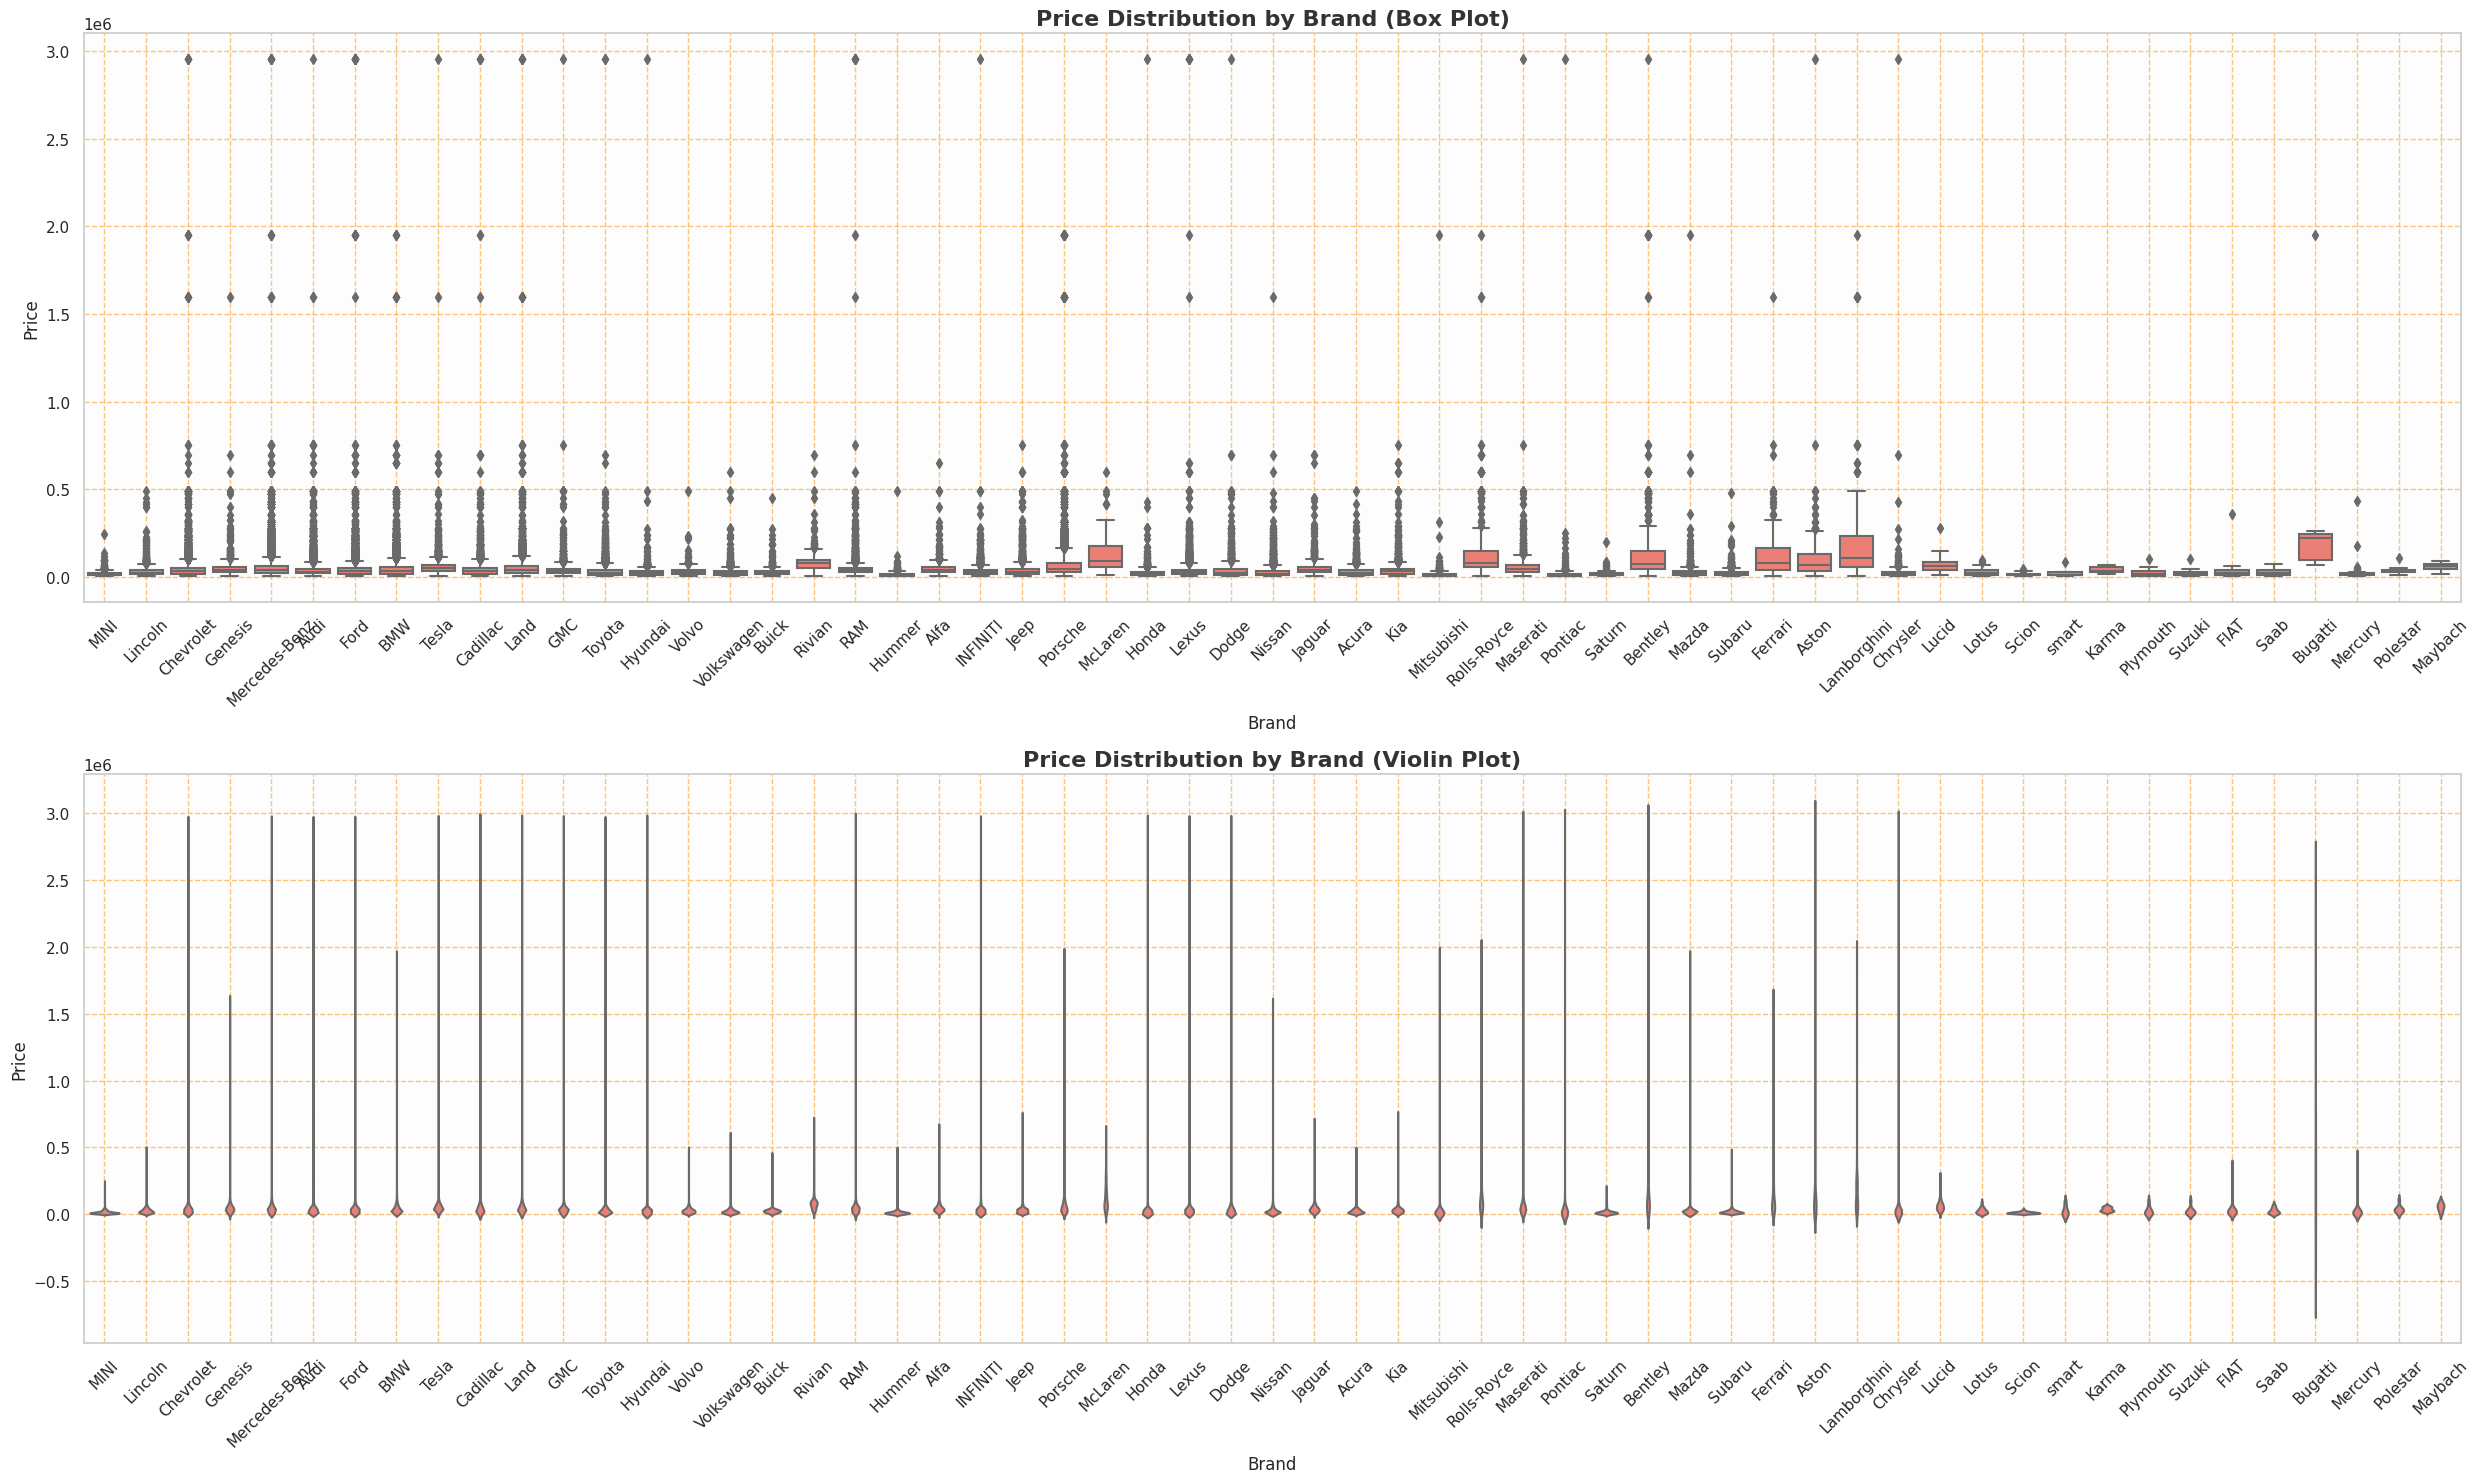

In [10]:
# Set up figure and axes
fig, ax = plt.subplots(2, 1, figsize=(25, 15))

# Define colors
colors = {'box': '#FF6F61', 'violin': '#FF6F61', 'bg': '#F5F5F5', 'grid': '#FFAB40', 'text': '#333333'}

# Set general aesthetic style
sns.set(style="whitegrid")

# Box Plot for Price by Brand
sns.boxplot(x='brand', y='price', data=train, ax=ax[0], color=colors['box'])
ax[0].set_title('Price Distribution by Brand (Box Plot)', fontsize=16, fontweight='bold', color=colors['text'])
ax[0].set(xlabel='Brand', ylabel='Price')
ax[0].patch.set(facecolor=colors['bg'], alpha=0.1)
ax[0].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])
ax[0].tick_params(axis='x', rotation=45)

# Violin Plot for Price by Brand
sns.violinplot(x='brand', y='price', data=train, ax=ax[1], color=colors['violin'], inner=None)
ax[1].set_title('Price Distribution by Brand (Violin Plot)', fontsize=16, fontweight='bold', color=colors['text'])
ax[1].set(xlabel='Brand', ylabel='Price')
ax[1].patch.set(facecolor=colors['bg'], alpha=0.1)
ax[1].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])
ax[1].tick_params(axis='x', rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


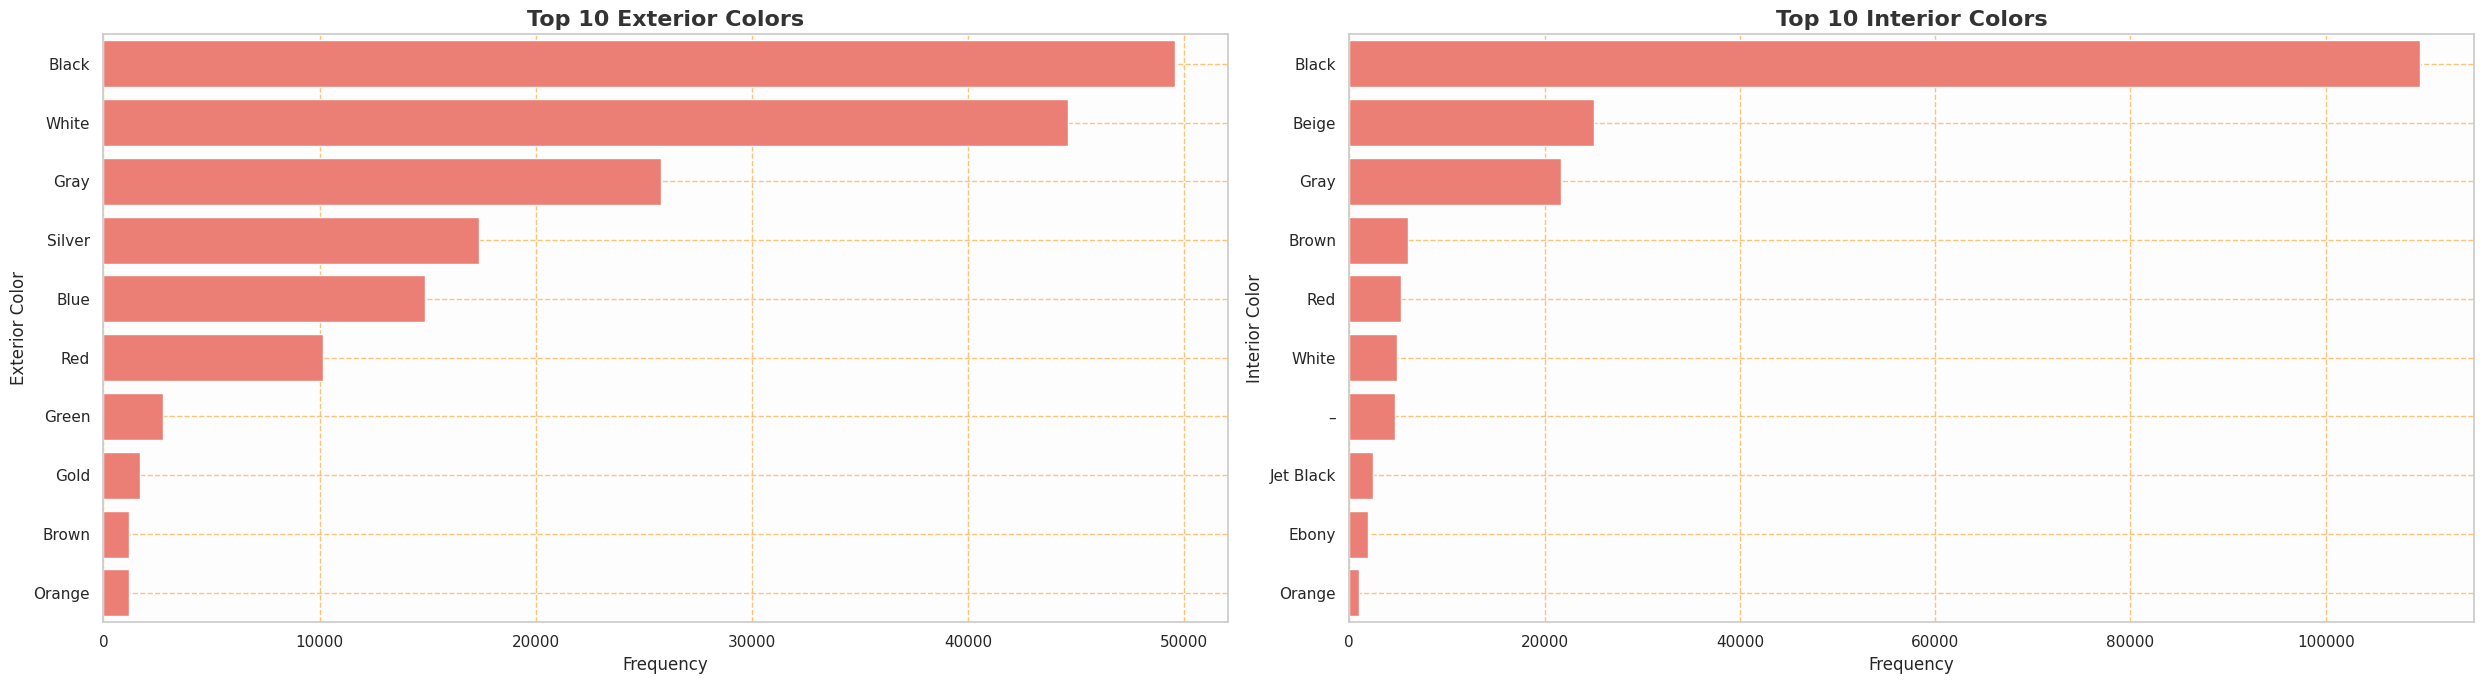

In [11]:
# Set up figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 7))

# Define colors
colors = {'bar': '#FF6F61', 'bg': '#F5F5F5', 'grid': '#FFAB40', 'text': '#333333'}

# Set general aesthetic style
sns.set(style="whitegrid")

# Bar Plot for Top 10 Exterior Colors
ext_color_counts = train['ext_col'].value_counts().head(10)
sns.barplot(x=ext_color_counts.values, y=ext_color_counts.index, ax=ax[0], color=colors['bar'])
ax[0].set_title('Top 10 Exterior Colors', fontsize=16, fontweight='bold', color=colors['text'])
ax[0].set(xlabel='Frequency', ylabel='Exterior Color')
ax[0].patch.set(facecolor=colors['bg'], alpha=0.1)
ax[0].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])

# Bar Plot for Top 10 Interior Colors
int_color_counts = train['int_col'].value_counts().head(10)
sns.barplot(x=int_color_counts.values, y=int_color_counts.index, ax=ax[1], color=colors['bar'])
ax[1].set_title('Top 10 Interior Colors', fontsize=16, fontweight='bold', color=colors['text'])
ax[1].set(xlabel='Frequency', ylabel='Interior Color')
ax[1].patch.set(facecolor=colors['bg'], alpha=0.1)
ax[1].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


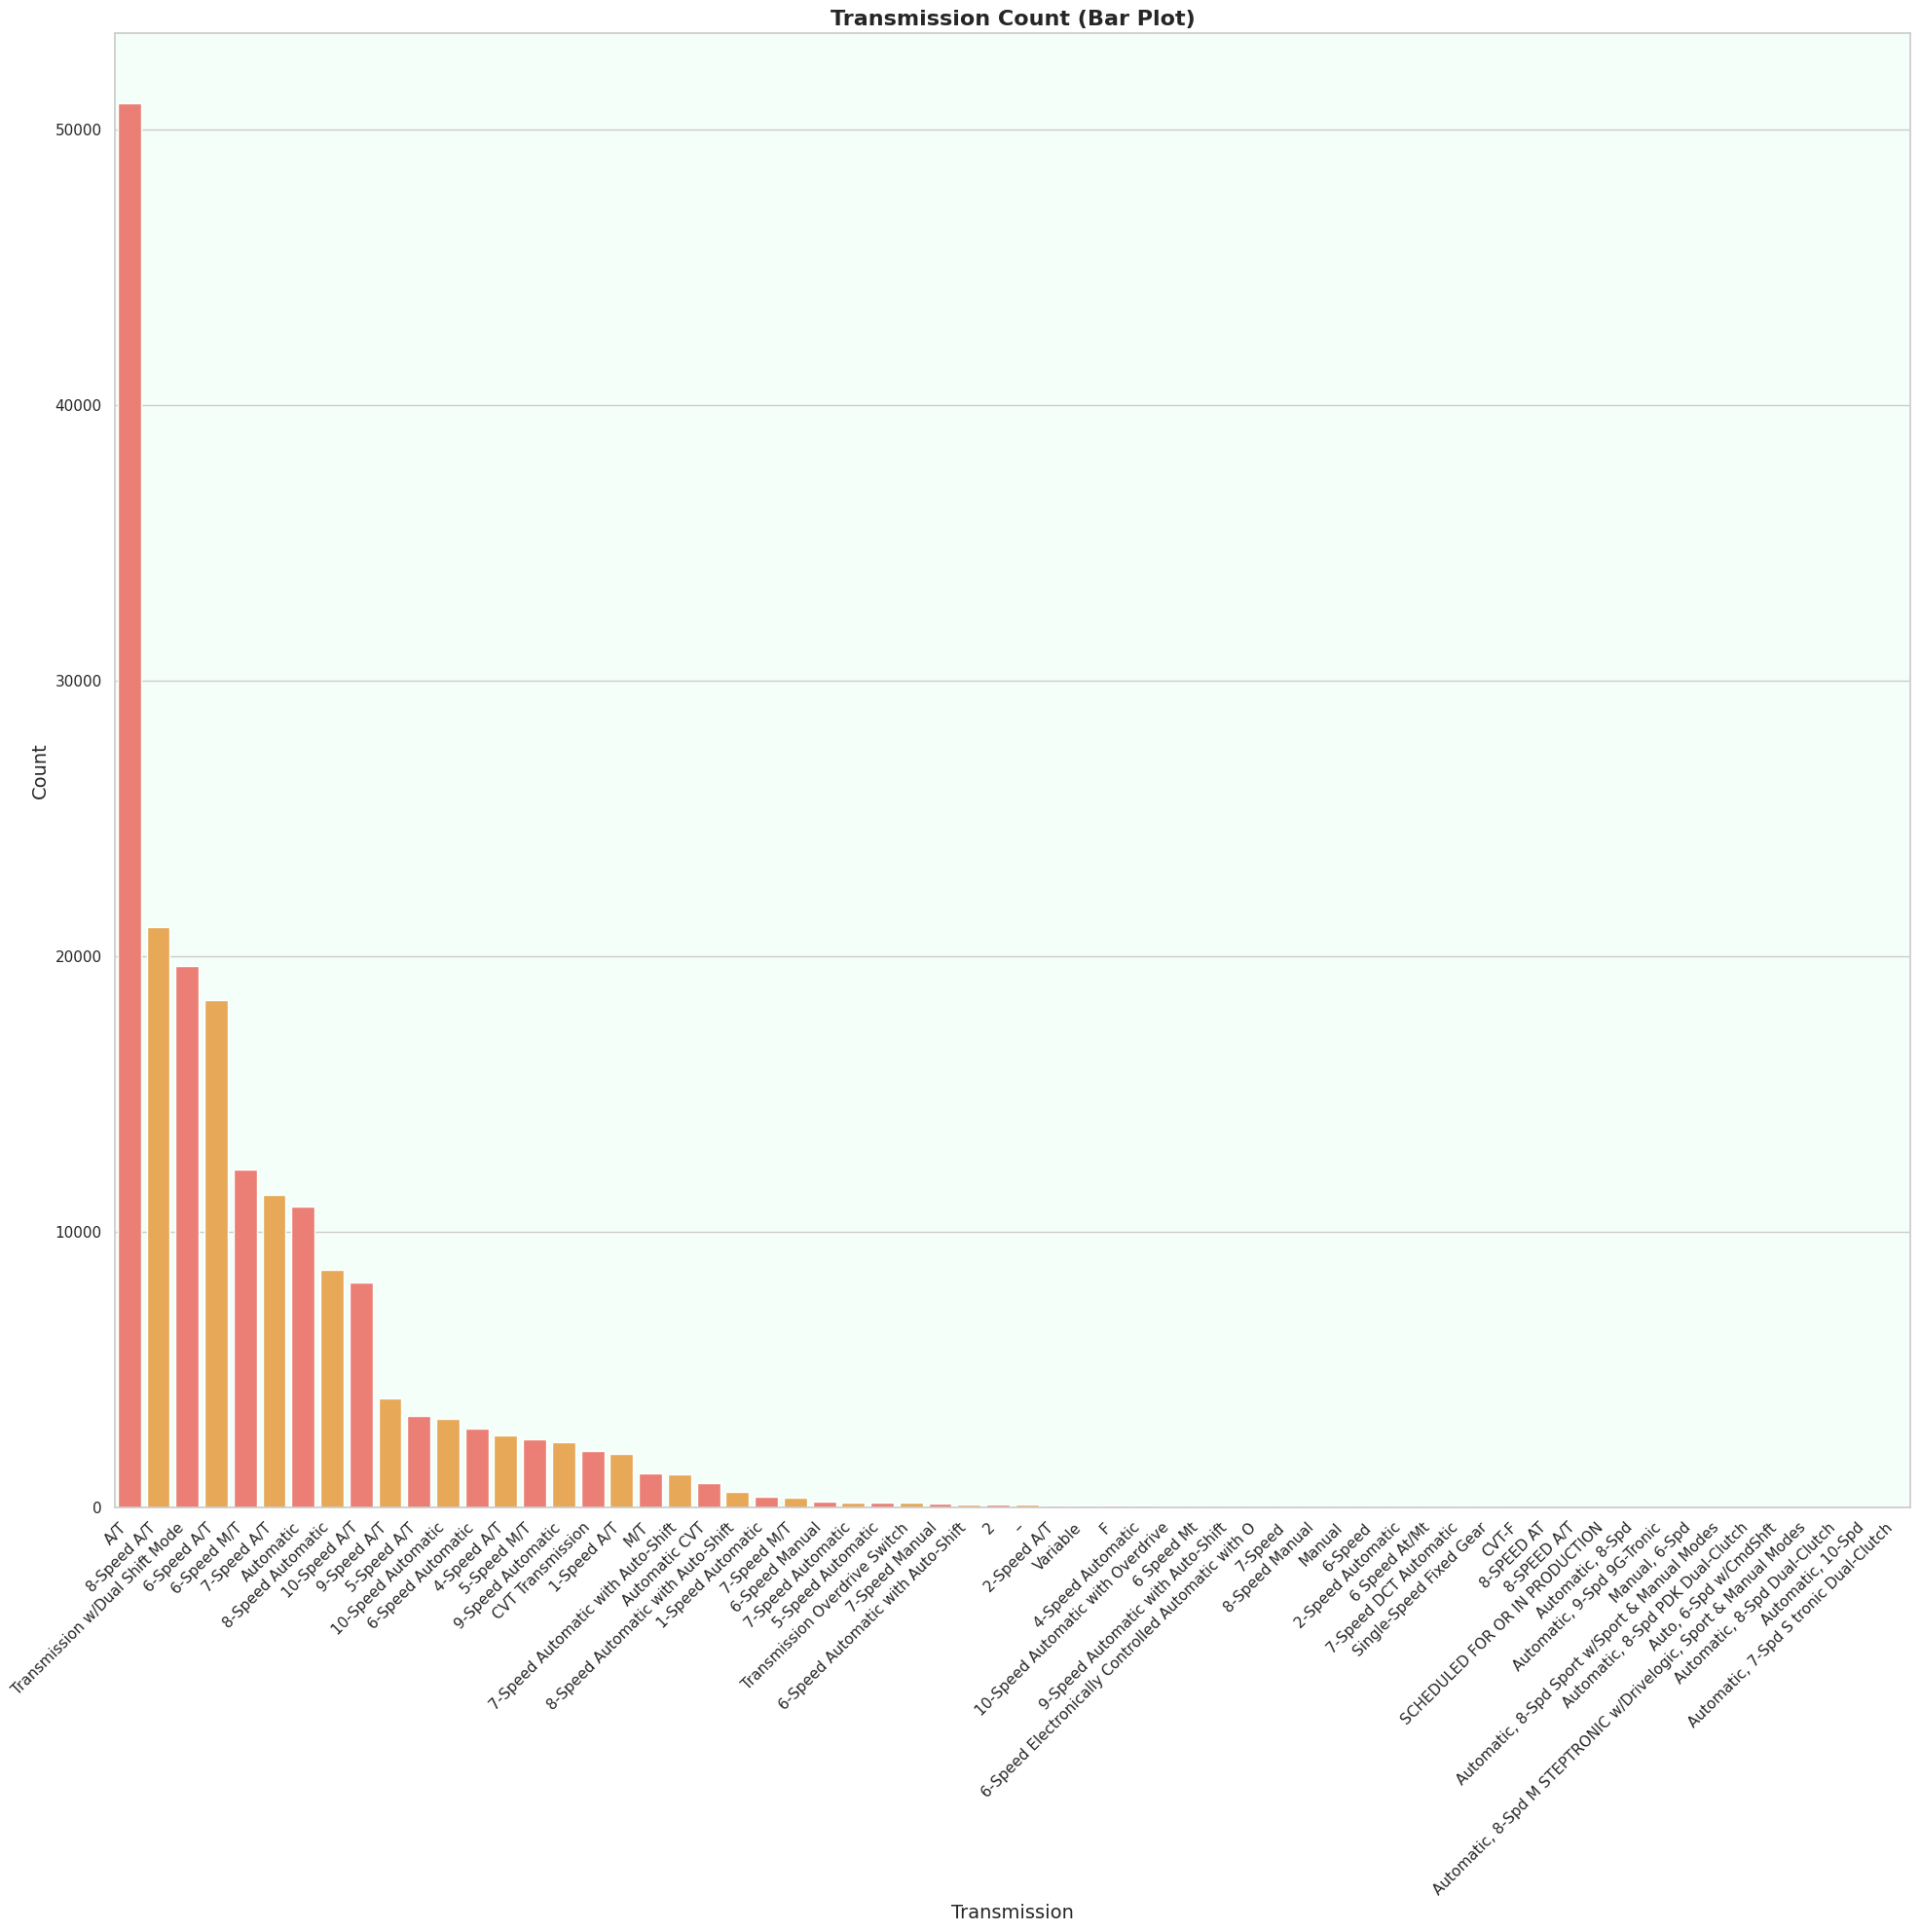

In [12]:
# Set up figure
plt.figure(figsize=(20, 20))

# Define custom color palette and create the count plot
sns.countplot(x='transmission', data=train, palette=['#FF6F61', '#FFAB40'], 
              order=train['transmission'].value_counts().index)

# Set title, labels, and rotate x-axis labels
plt.title('Transmission Count (Bar Plot)', fontsize=16, fontweight='bold')
plt.xlabel('Transmission', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Set background color and adjust layout
plt.gca().set_facecolor('#F5FFFA')
plt.tight_layout()

# Show plot
plt.show()


In [13]:
train.isna().sum()

id               4009
brand               0
model               0
model_year          0
milage              0
fuel_type        5253
engine              0
transmission        0
ext_col             0
int_col             0
accident         2565
clean_title     22015
price               0
dtype: int64

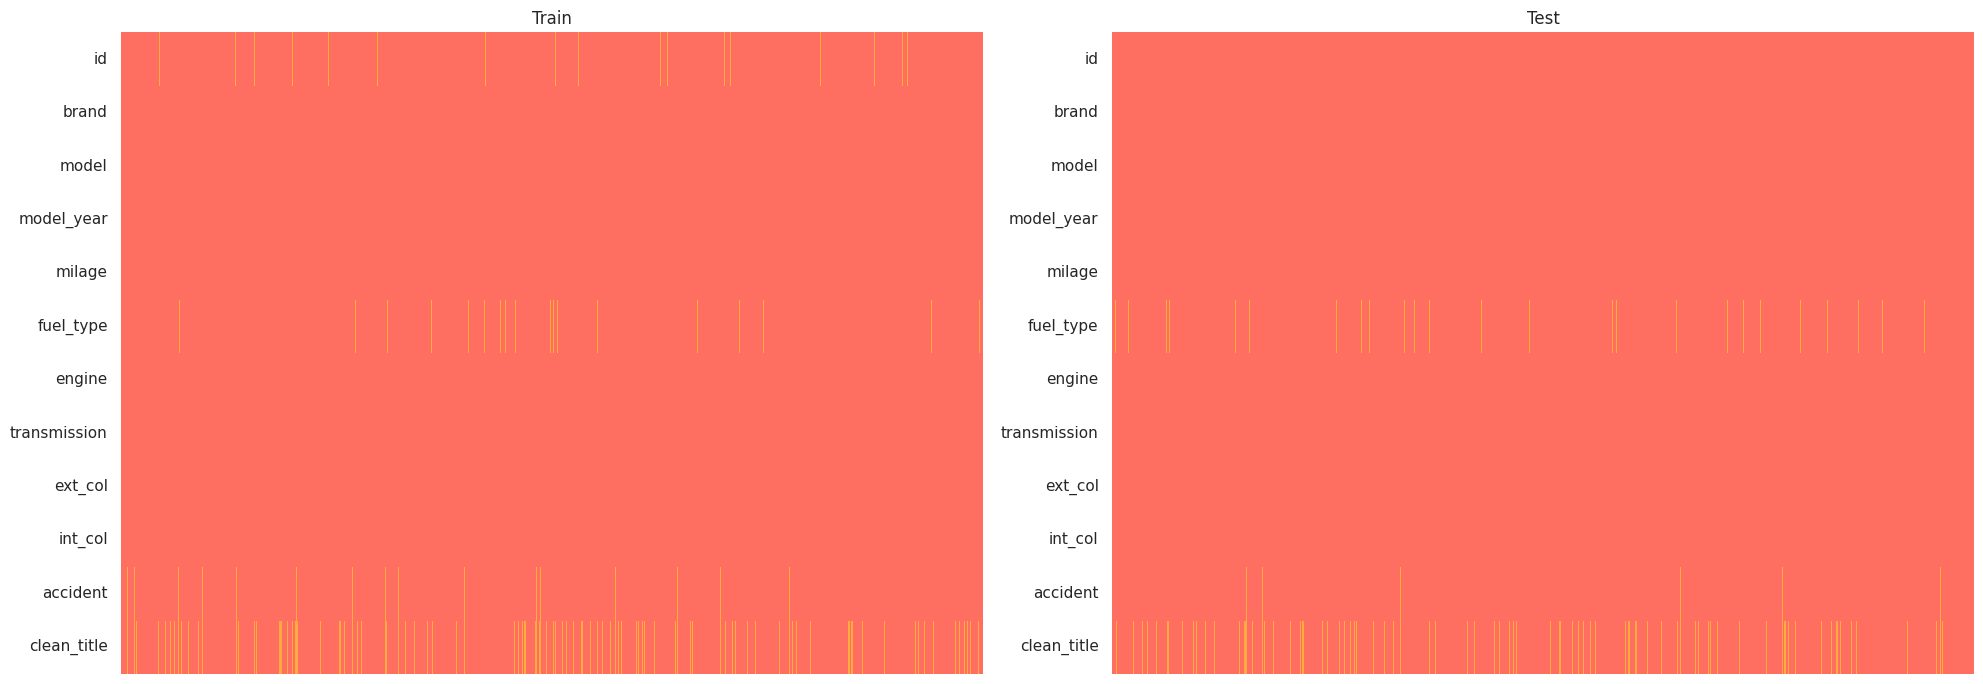

In [14]:
# Custom color palette
custom_palette = ['#FF6F61', '#FFAB40']

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette, N=256)

# Sample data for null values heatmap
train_null_values = train.sample(100_000).drop(columns=['price']).isnull().T
test_null_values = test.sample(100_000).isnull().T

# Plotting the heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

sns.heatmap(train_null_values, cbar=False, cmap=cmap, ax=axes[0])
axes[0].set_title('Train')
axes[0].set_xticks([]) 
axes[0].set_xlabel('')

sns.heatmap(test_null_values, cbar=False, cmap=cmap, ax=axes[1])
axes[1].set_title('Test')
axes[1].set_xticks([]) 
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

In [15]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

In [16]:
cat_features = test.select_dtypes('object').columns

for feature in cat_features:
    categories = sorted(train[feature].dropna().unique())
    dtype = pd.CategoricalDtype(categories=categories, ordered=False)
    
    train[feature] = pd.Series(np.where(train[feature].isin(categories), train[feature], np.nan), dtype=dtype)
    test[feature] = pd.Series(np.where(test[feature].isin(categories), test[feature], np.nan), dtype=dtype)

In [20]:
X_train = train.drop(columns=["id", "price"])
y_train = train["price"]

X_test = test.drop(columns=["id"])

In [21]:
#I have used 5 splits here.
def cross_validate_model_x(model, X_train, y_train, params, n_splits=5):

    # Initialize variables
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_scores = []
    test_preds = np.zeros((len(X_test), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]
        
        # Model initialization and training
        clf = model(**params, enable_categorical=True)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train,  eval_set=[(X_val, y_val)],verbose=500, early_stopping_rounds=50)
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(X_test)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    return clf,test_preds

In [22]:
xgb_params={
    
    
     'lambda': 0.03880258557285165,
     'alpha': 0.02129832295514386,
     'colsample_bytree': 0.4,
     'subsample': 0.7,
     'learning_rate': 0.05,
     'max_depth': 17,
     'random_state': 2020,
     'min_child_weight': 85,
     'n_estimators': 10000,
     'tree_method': 'gpu_hist'
 
}


print('XGBoost Cross-Validation Results:\n')
xgb_model, test_predsx = cross_validate_model_x(XGBRegressor, X_train, y_train, xgb_params)

XGBoost Cross-Validation Results:

[0]	validation_0-rmse:80739.86245
[122]	validation_0-rmse:75257.63716
--------------------------------------------------
[[18183.693     0.        0.        0.        0.   ]
 [69487.6       0.        0.        0.        0.   ]
 [51902.637     0.        0.        0.        0.   ]
 ...
 [20622.768     0.        0.        0.        0.   ]
 [17110.406     0.        0.        0.        0.   ]
 [43070.34      0.        0.        0.        0.   ]]
[0]	validation_0-rmse:74211.18050
[147]	validation_0-rmse:68076.71434
--------------------------------------------------
[[18183.693 15904.502     0.        0.        0.   ]
 [69487.6   82503.12      0.        0.        0.   ]
 [51902.637 48406.438     0.        0.        0.   ]
 ...
 [20622.768 20854.414     0.        0.        0.   ]
 [17110.406 15359.967     0.        0.        0.   ]
 [43070.34  32637.254     0.        0.        0.   ]]
[0]	validation_0-rmse:75634.24997
[142]	validation_0-rmse:69524.60445
-----

In [23]:
xgb_result =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
xgb_result['price'] = test_predsx.astype(np.float32)
xgb_result

,id,price
0,188533,16341.307617
1,188534,79339.593750
2,188535,54044.363281
3,188536,30226.902344
4,188537,28287.707031
...,...,...
125685,314218,34734.332031
125686,314219,47322.316406
125687,314220,19471.652344
125688,314221,15832.221680


In [24]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
Original = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')


Original[['milage', 'price']] = Original[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))

train = pd.concat([train, Original], ignore_index=True)

In [25]:
def update(df):
    
    t = 100
    
    cat_c = ['brand','model','fuel_type','engine','transmission','ext_col','int_col','accident','clean_title']
    re_ = ['model','engine','transmission','ext_col','int_col']
    
    for col in re_:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < t, col] = "noise"
        
    for col in cat_c:
        df[col] = df[col].fillna('missing')
        df[col] = df[col].astype('category')
        
    return df

train  = update(train)
test   = update(test)

In [26]:
X_train = train.drop(columns=["id", "price"])
y_train = train["price"]

X_test = test.drop(columns=["id"])

In [27]:
def cross_validate_model_l(model, X_train, y_train, params, n_splits=5):

    # Initialize variables
    callbacks = [log_evaluation(period=150), early_stopping(stopping_rounds=200)]
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_scores = []
    test_preds = np.zeros((len(X_test), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]
        
        # Model initialization and training
        clf = model(**params)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train, eval_set=[(X_val, y_val)], callbacks=callbacks )
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(X_test)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    return clf,test_preds

In [28]:
from lightgbm import LGBMRegressor

lgb_params = {
    'learning_rate': 0.017521301504983752,
    'max_depth': 42,
    'reg_alpha': 0.06876635751774487, 
    'reg_lambda': 9.738899198284985,
    'num_leaves': 131,
    'subsample': 0.2683765421728044,
    'colsample_bytree': 0.44346036599709887,
    'n_estimators': 10000,
    'random_state': 42          # Set to -1 for silent mode, no process information printed
}

print('LightGBM Cross-Validation Results:\n')
lgb_model,test_predsl = cross_validate_model_l(LGBMRegressor, X_train, y_train, lgb_params)

LightGBM Cross-Validation Results:

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 154033, number of used features: 11
[LightGBM] [Info] Start training from score 43824.155038
Training until validation scores don't improve for 200 rounds
[150]	valid_0's l2: 5.66054e+09
[300]	valid_0's l2: 5.67473e+09
Early stopping, best iteration is:
[183]	valid_0's l2: 5.65474e+09
--------------------------------------------------
[[19522.36      0.        0.        0.        0.   ]
 [73475.57      0.        0.        0.        0.   ]
 [49053.133     0.        0.        

In [29]:
lgb_result =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
lgb_result['price'] = test_predsl.astype(np.float32)
#xgb_result.to_csv('result_xgb.csv', index=False)
lgb_result

,id,price
0,188533,18849.113281
1,188534,77458.843750
2,188535,49821.082031
3,188536,31901.427734
4,188537,29342.431641
...,...,...
125685,314218,33261.609375
125686,314219,59970.062500
125687,314220,21136.542969
125688,314221,16652.267578


In [30]:
#I have used 5 splits here.
def cross_validate_model_c(model, X_train, y_train, params, n_splits=5):

    # Initialize variables
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    val_scores = []
    test_preds = np.zeros((len(X_test), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]
        
        # Model initialization and training
        clf = model(**params)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train, eval_set=[(X_val, y_val)], verbose=0)
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(X_test)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    return clf,test_preds

In [31]:
from catboost import CatBoostClassifier

cat_params = {
    'learning_rate':0.042,
    'iterations':2000,
    'depth':10,
    'random_strength':0,
    'cat_features':cat_cols,
    'l2_leaf_reg':0.3,
    'random_seed':42,
    'early_stopping_rounds': 200,
    'task_type':'GPU',                      
}

print('CatBoost Cross-Validation Results:\n')
cat_model, test_predsc = cross_validate_model_c(CatBoostRegressor, X_train, y_train, cat_params)

CatBoost Cross-Validation Results:

--------------------------------------------------
[[17668.988     0.        0.        0.        0.   ]
 [77123.125     0.        0.        0.        0.   ]
 [56795.754     0.        0.        0.        0.   ]
 ...
 [20562.691     0.        0.        0.        0.   ]
 [15676.219     0.        0.        0.        0.   ]
 [34846.203     0.        0.        0.        0.   ]]
--------------------------------------------------
[[17668.988 17894.703     0.        0.        0.   ]
 [77123.125 81346.59      0.        0.        0.   ]
 [56795.754 54423.848     0.        0.        0.   ]
 ...
 [20562.691 22114.54      0.        0.        0.   ]
 [15676.219 16680.842     0.        0.        0.   ]
 [34846.203 37180.773     0.        0.        0.   ]]
--------------------------------------------------
[[17668.988 17894.703 18820.021     0.        0.   ]
 [77123.125 81346.59  85356.13      0.        0.   ]
 [56795.754 54423.848 54753.31      0.        0.   ]
 ...

In [32]:
cat_result =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
cat_result['price'] = test_predsc.astype(np.float32)
cat_result

,id,price
0,188533,18208.472656
1,188534,79623.203125
2,188535,56425.925781
3,188536,31001.175781
4,188537,32621.556641
...,...,...
125685,314218,31284.037109
125686,314219,56621.167969
125687,314220,21139.183594
125688,314221,16094.317383


In [33]:
Pred = pd.concat([lgb_result,cat_result,xgb_result], axis=1)['price']
print(Pred)
test_preds = test_predsl * 0.6 + test_predsc * 0.1 + test_predsx*0.3

               price         price         price
0       18849.113281  18208.472656  16341.307617
1       77458.843750  79623.203125  79339.593750
2       49821.082031  56425.925781  54044.363281
3       31901.427734  31001.175781  30226.902344
4       29342.431641  32621.556641  28287.707031
...              ...           ...           ...
125685  33261.609375  31284.037109  34734.332031
125686  59970.062500  56621.167969  47322.316406
125687  21136.542969  21139.183594  19471.652344
125688  16652.267578  16094.317383  15832.221680
125689  47201.332031  35858.945312  42004.632812

[125690 rows x 3 columns]


In [35]:
ensemble_sub =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
ensemble_sub['price'] = test_preds

ensemble_sub.to_csv('submission3.csv', index=False)